# Text Classification for Craigslist Posts

Author : Theofilus Arifin

---


# Introduction

**Table Of Content**

- Introduction
- Load Dataset
- Data Cleaning
- Exploratory Data Analysis
- Data Preprocessing
- Feature Engineering
- Data Modeling
- Model Evaluation
- Business Recomendation

**Background**

Craigslist is a widely utilized platform for local classified advertisements, offering a variety of sections such as jobs, housing, services, and more. Within each section, there are numerous categories tailored to specific needs, ranging from automotive to household services. With the vast amount of data available on Craigslist, there is an opportunity to leverage machine learning techniques for text classification to predict the category of each post.

**Objective**

- Train a text classification model using machine learning algorithms and provided data to accurately predict Craigslist post categories.
- Implement a user-friendly interface using Streamlit to enable users to input data and receive predicted categories efficiently.
- Iterate on the model based on user feedback and performance metrics to enhance accuracy and usability.

**Goals**

Develop and deploy a machine learning model for text classification to predict the category of Craigslist posts, while creating an intuitive user interface for seamless interaction.

# Load Dataset

In [80]:
import sklearn
print(sklearn.__version__)

1.4.0


In [81]:
!pip install -U scikit-learn==1.4

In [82]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [83]:
!git clone "https://github.com/Theofilusarifin/Text-Classification-for-Craigslist-Posts.git"

fatal: destination path 'Text-Classification-for-Craigslist-Posts' already exists and is not an empty directory.


In [84]:
with open('/content/Text-Classification-for-Craigslist-Posts/dataset/training.json', 'r') as f:
    data = [json.loads(line) for line in f.readlines()[1:]]

train = pd.concat([pd.DataFrame([d]) for d in data], ignore_index=True)
train.head()

,city,category,section,heading
0,newyork,cell-phones,for-sale,New batteries C-S2 for Blackberry 7100/7130/87...
1,newyork,cell-phones,for-sale,******* Brand New Original SAMSUNG GALAXY NO...
2,newyork,cell-phones,for-sale,SAMSUNG GALAXY SIII T-999 MARBLE WHITE T-MOBIL...
3,newyork,cell-phones,for-sale,Ipad mini 64gb 4g any sim unlock
4,newyork,cell-phones,for-sale,htc evo 4g lte for trade


In [85]:
with open('/content/Text-Classification-for-Craigslist-Posts/dataset/sample-test.in.json', 'r') as f:
    data = [json.loads(line) for line in f.readlines()[1:]]

test = pd.concat([pd.DataFrame([d]) for d in data], ignore_index=True)
test.head()

,city,section,heading
0,chicago,for-sale,Madden NFL 25 XBOX 360. Brand New!
1,paris.en,housing,looking for room to rent.
2,newyork,for-sale,two DS game
3,seattle,housing,map
4,singapore,services,Good Looking Asian Sensation N aughty Girl ---...


## Dataset Overview

---



| Feature | Description                                                                                   |
|---------|-----------------------------------------------------------------------------------------------|
| City    | The city associated with the Craigslist post, indicating the location of the item or service.|
| Category| The category to which the Craigslist post belongs, specifying the type of item or service.   |
| Section | The section of Craigslist where the post is listed, such as "for-sale", "housing", etc.      |
| Heading | The heading or title of the Craigslist post, providing a brief description of the item/service.|


In [86]:
list_item = []
for col in train.columns:
    list_item.append([col, train[col].dtype, train[col].isna().sum(), round(100*train[col].isna().sum()/len(train[col]), 2), train[col].nunique(), train[col].unique()[:5]])
desc_train = pd.DataFrame(data=list_item, columns='feature, data_type, null_values, null_percentage, unique_values, unique_sample'.split(","))
desc_train

,feature,data_type,null_values,null_percentage,unique_values,unique_sample
0,city,object,0,0.0,16,"[newyork, seattle, chicago, london, manchester]"
1,category,object,0,0.0,16,"[cell-phones, appliances, photography, video-g..."
2,section,object,0,0.0,4,"[for-sale, housing, community, services]"
3,heading,object,0,0.0,15372,[New batteries C-S2 for Blackberry 7100/7130/8...


In [87]:
list_item = []
for col in test.columns:
    list_item.append([col, test[col].dtype, test[col].isna().sum(), round(100*test[col].isna().sum()/len(test[col]), 2), test[col].nunique(), test[col].unique()[:5]])
desc_test = pd.DataFrame(data=list_item, columns='feature, data_type, null_values, null_percentage, unique_values, unique_sample'.split(","))
desc_test

,feature,data_type,null_values,null_percentage,unique_values,unique_sample
0,city,object,0,0.0,16,"[chicago, paris.en, newyork, seattle, singapore]"
1,section,object,0,0.0,4,"[for-sale, housing, services, community]"
2,heading,object,0,0.0,11911,"[Madden NFL 25 XBOX 360. Brand New!, looking ..."


In [88]:
train.city.value_counts().reset_index().sort_values('index')

,index,city
6,bangalore,585
1,chicago,4469
10,delhi,216
7,dubai.en,454
14,frankfurt.en,4
12,geneva.en,5
9,hyderabad,260
13,kolkata.en,5
4,london,1663
11,manchester,7


In [89]:
test.city.value_counts().reset_index().sort_values('index')

,index,city
6,bangalore,441
1,chicago,3355
9,delhi,186
7,dubai.en,331
14,frankfurt.en,3
12,geneva.en,4
8,hyderabad,218
15,kolkata.en,2
4,london,1200
11,manchester,5


In [90]:
train.duplicated().sum()

4695

# Data Cleaning

In [91]:
train1 = train.copy()

## Handle Duplicated Data

---



In [92]:
train1 = train1.drop_duplicates()

In [93]:
train1.duplicated().sum()

0

# EDA

In [94]:
train1_forsale = train1[train1['section'] == 'for-sale']
train1_forsale.category.value_counts()

cell-phones    1546
photography    1190
appliances     1103
video-games    1074
Name: category, dtype: int64

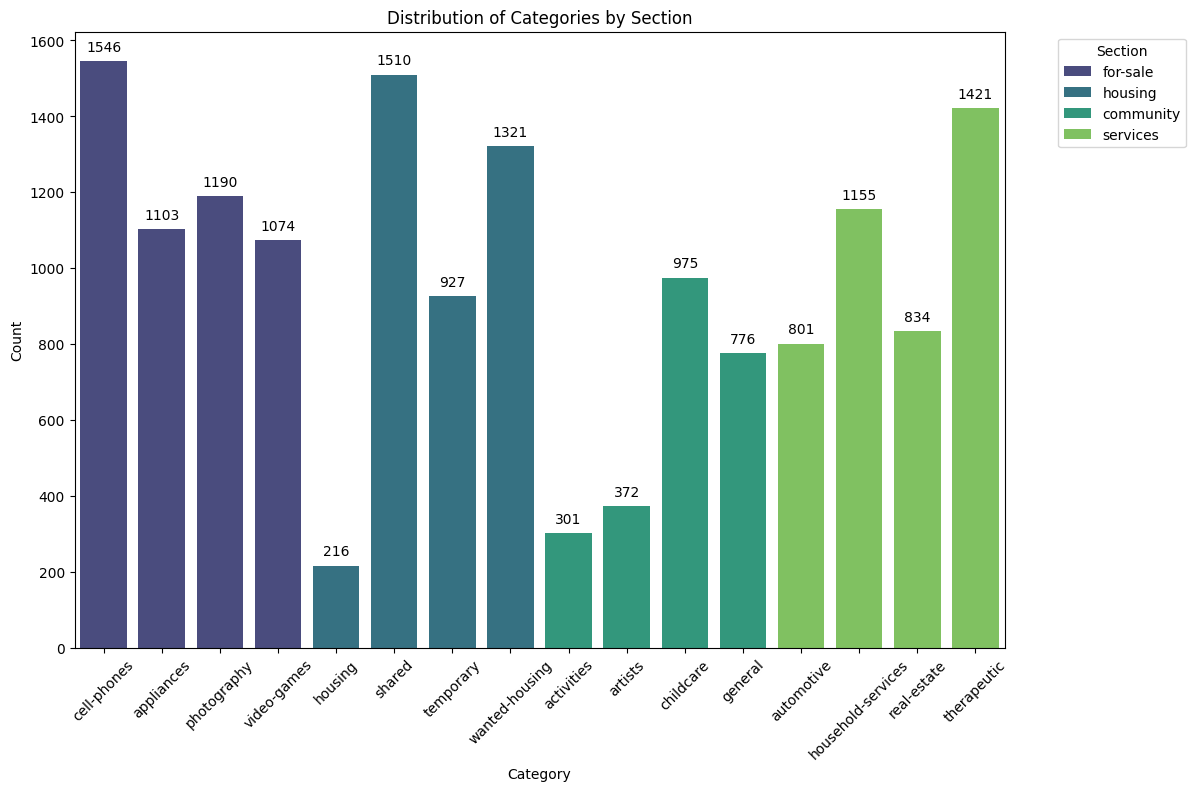

In [95]:
df_long = train1.melt(id_vars=['category'], value_vars=['section'])

# Plot stacked bar chart using seaborn's countplot
plt.figure(figsize=(12, 8))
ax = sns.countplot(data=df_long, x='category', hue='value', palette='viridis')
plt.title('Distribution of Categories by Section')
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Section', bbox_to_anchor=(1.05, 1), loc='upper left')

# Add count number on top of each bar
for p in ax.patches:
  if p.get_height()>0:
    ax.annotate(format(p.get_height(), '.0f'),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center',
                xytext = (0, 10),
                textcoords = 'offset points')

plt.show()

It is shown that each category is representated by a unique section. Therefore we can split the data based on the section to create a unique model for each section

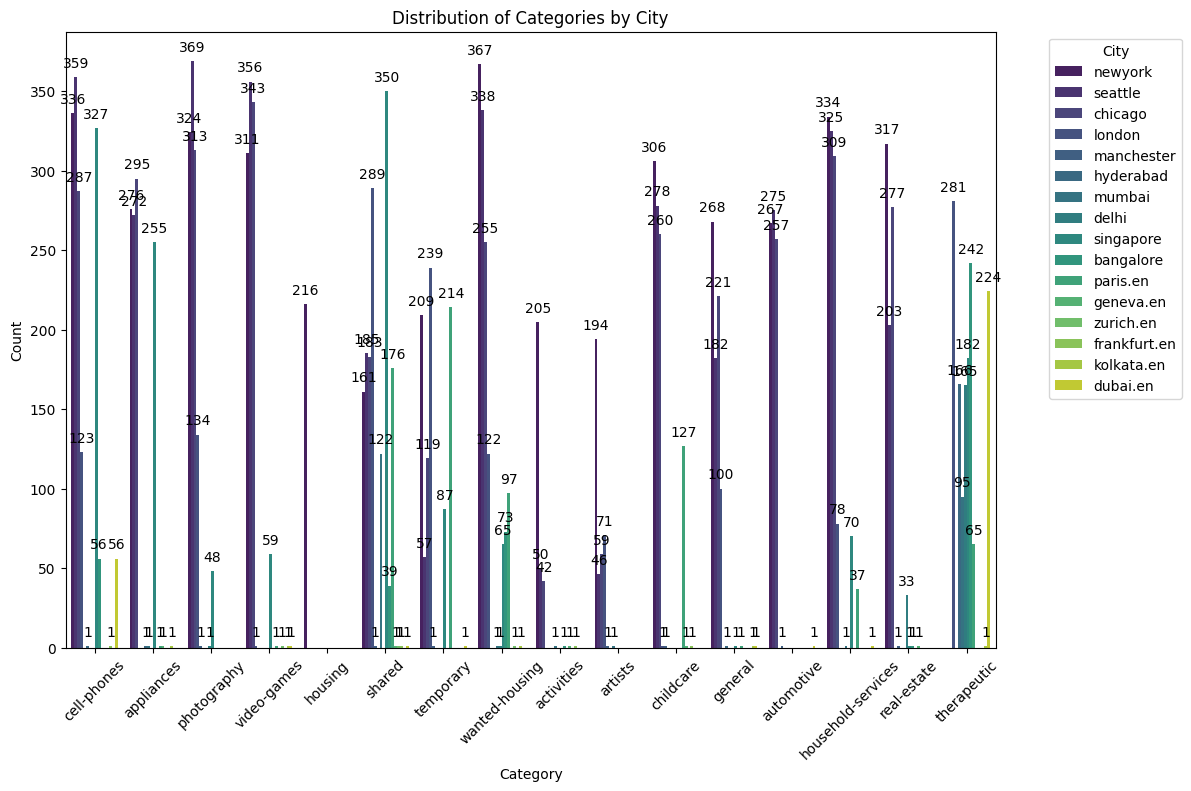

In [96]:
df_long = train1.melt(id_vars=['category'], value_vars=['city'])

# Plot stacked bar chart using seaborn's countplot
plt.figure(figsize=(12, 8))
ax = sns.countplot(data=df_long, x='category', hue='value', palette='viridis')
plt.title('Distribution of Categories by City')
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='City', bbox_to_anchor=(1.05, 1), loc='upper left')

# Add count number on top of each bar
for p in ax.patches:
  if p.get_height()>0:
    ax.annotate(format(p.get_height(), '.0f'),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center',
                xytext = (0, 10),
                textcoords = 'offset points')

plt.show()

# Data Preprocessing

In [97]:
train_pre = train1.copy()

## One Hot Encoding

---



### City

Every city will be one hot encoded by the city unique name and the city feature will be dropped

In [98]:
def city_encoded(dataset):
  train_encoded = ['bangalore', 'chicago', 'delhi', 'dubai.en', 'frankfurt.en', 'geneva.en', 'hyderabad', 'kolkata.en', 'london', 'manchester', 'mumbai', 'newyork', 'paris.en', 'seattle', 'singapore', 'zurich.en']
  dataset_encoded = pd.get_dummies(dataset['city'])
  dataset_encoded = dataset_encoded[train_encoded]

  dataset.drop(columns = ['city'], axis=1, inplace=True)
  dataset = pd.concat([dataset, dataset_encoded], axis=1)

  return dataset

In [99]:
train_pre = city_encoded(train_pre)
train_pre.head(3)

,category,section,heading,bangalore,chicago,delhi,dubai.en,frankfurt.en,geneva.en,hyderabad,kolkata.en,london,manchester,mumbai,newyork,paris.en,seattle,singapore,zurich.en
0,cell-phones,for-sale,New batteries C-S2 for Blackberry 7100/7130/87...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,cell-phones,for-sale,******* Brand New Original SAMSUNG GALAXY NO...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,cell-phones,for-sale,SAMSUNG GALAXY SIII T-999 MARBLE WHITE T-MOBIL...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


In [100]:
test = city_encoded(test)
test.head(3)

,section,heading,bangalore,chicago,delhi,dubai.en,frankfurt.en,geneva.en,hyderabad,kolkata.en,london,manchester,mumbai,newyork,paris.en,seattle,singapore,zurich.en
0,for-sale,Madden NFL 25 XBOX 360. Brand New!,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,housing,looking for room to rent.,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2,for-sale,two DS game,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


## Text Processing

---



In [101]:
train_sentiment = pd.DataFrame(train_pre['heading'])
train_pre.drop('heading', axis=1, inplace=True)

In [102]:
train_sentiment.head()

,heading
0,New batteries C-S2 for Blackberry 7100/7130/87...
1,******* Brand New Original SAMSUNG GALAXY NO...
2,SAMSUNG GALAXY SIII T-999 MARBLE WHITE T-MOBIL...
3,Ipad mini 64gb 4g any sim unlock
4,htc evo 4g lte for trade


In [103]:
test_sentiment = pd.DataFrame(test['heading'])
test.drop('heading', axis=1, inplace=True)

In [104]:
test_sentiment.head()

,heading
0,Madden NFL 25 XBOX 360. Brand New!
1,looking for room to rent.
2,two DS game
3,map
4,Good Looking Asian Sensation N aughty Girl ---...


In [105]:
!pip install emoji

### Text Cleaning

In [106]:
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
import emoji
import joblib

In [107]:
def count_changes(initial_df, df_after_step):
    return (initial_df != df_after_step).any(axis=1).sum()

In [108]:
def split_camel_case_hashtag(text):
    words = text.split()
    for i, word in enumerate(words):
        if word.startswith('#'):
            # Remove the leading '#' and split camel case words
            words[i] = words[i].replace('#', '')
            words[i] = re.sub(r'([a-z])([A-Z])', r'\1 \2', words[i])
    return ' '.join(words).lower()

In [109]:
def remove_string_emoticons(text):
    # Remove emoticons (e.g., :), :-), :D, ...)
    emoticon_pattern = r'(?::|;|=)(?:-)?(?:\)|\(|D|P)'
    text = re.sub(emoticon_pattern, '', text)

    return text

In [110]:
def remove_emoji(text):
    # Mengubah emoji menjadi string
    # 😆 -> :happy:
    text = emoji.demojize(text)

    # Menghapus string emoji
    text = re.sub(r':[a-z_]+:', '', text)
    return text

In [111]:
def clean_URLs(text):
    return re.sub(r"((www.[^s]+)|(http\S+))","",text)

In [112]:
def clean_punctuations(text):
    punctuations = string.punctuation
    translator = str.maketrans(punctuations.replace("'", ''), ' ' * (len(punctuations) - 1))
    text = text.translate(translator)
    text = re.sub(' +', ' ', text) #Remove extra space
    text = re.sub(r'\'', '', text)
    return text

In [113]:
def clean_numeric(text):
    return re.sub('[0-9]+', '', text)

In [114]:
nltk.download('punkt', download_dir='./ntlk_data')

[nltk_data] Downloading package punkt to ./ntlk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [115]:
nltk.download('wordnet', download_dir='./ntlk_data')

[nltk_data] Downloading package wordnet to ./ntlk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [116]:
nltk.download('stopwords', download_dir='./ntlk_data')

[nltk_data] Downloading package stopwords to ./ntlk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [117]:
# Initialize the Porter stemmer and WordNet lemmatizer
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Get English stopwords
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    # Tokenize the text
    tokens = word_tokenize(text)

    # Perform stemming, lemmatization, and stopword removal
    filtered_tokens = [lemmatizer.lemmatize(token) for token in tokens if token.lower() not in stop_words]

    # Join the tokens back into a string
    preprocessed_text = ' '.join(filtered_tokens)

    return preprocessed_text

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [118]:
# Save the stemmer
joblib.dump(stemmer, 'stemmer.joblib')

# Save the lemmatizer
joblib.dump(lemmatizer, 'lemmatizer.joblib')

['lemmatizer.joblib']

In [119]:
def text_proccessing(dataset):

  initial_df = dataset.copy()
  dataset['heading'] = dataset['heading'].apply(lambda x : split_camel_case_hashtag(x))
  print("Banyak perubahan pada step split_camel_case_hashtag = " , count_changes(initial_df, dataset))

  initial_df = dataset.copy()
  dataset['heading'] = dataset['heading'].str.lower()
  print("Banyak perubahan pada step lowercasing = " , count_changes(initial_df, dataset))

  initial_df = dataset.copy()
  dataset['heading'] = dataset['heading'].apply(lambda x : remove_string_emoticons(x))
  print("Banyak perubahan pada step remove string emoticon = " , count_changes(initial_df, dataset))

  initial_df = dataset.copy()
  dataset['heading'] = dataset['heading'].apply(lambda x : remove_emoji(x))
  print("Banyak perubahan pada step remove emoji = " , count_changes(initial_df, dataset))

  initial_df = dataset.copy()
  dataset['heading'] = dataset['heading'].apply(lambda x : clean_URLs(x))
  print("Banyak perubahan pada step clean url = " , count_changes(initial_df, dataset))

  initial_df = dataset.copy()
  dataset['heading'] = dataset['heading'].apply(lambda x : clean_punctuations(x))
  print("Banyak perubahan pada step clean punctuations = " , count_changes(initial_df, dataset))

  initial_df = dataset.copy()
  dataset['heading'] = dataset['heading'].apply(lambda x: clean_numeric(x))
  print("Banyak perubahan pada step clean numeric = " , count_changes(initial_df, dataset))

  initial_df = dataset.copy()
  dataset["heading"] = dataset["heading"].apply(lambda text: preprocess_text(text))
  print("Banyak perubahan pada step lemmatization and stopword = " , count_changes(initial_df, dataset))

  return dataset

In [120]:
train_sentiment.to_csv('./train_sentiment.csv', index=False)

In [121]:
train_sentiment_processed = train_sentiment.copy()

In [122]:
train_sentiment_processed = text_proccessing(train_sentiment_processed)

Banyak perubahan pada step split_camel_case_hashtag =  14416
Banyak perubahan pada step lowercasing =  0
Banyak perubahan pada step remove string emoticon =  35
Banyak perubahan pada step remove emoji =  9
Banyak perubahan pada step clean url =  38
Banyak perubahan pada step clean punctuations =  9495
Banyak perubahan pada step clean numeric =  7013
Banyak perubahan pada step lemmatization and stopword =  12884


In [123]:
train_sentiment_processed.to_csv('./train_sentiment_processed.csv', index=False)

In [124]:
test_sentiment.to_csv('./test_sentiment.csv', index=False)

In [125]:
test_sentiment_processed = test_sentiment.copy()

In [126]:
test_sentiment_processed = text_proccessing(test_sentiment_processed)

Banyak perubahan pada step split_camel_case_hashtag =  12490
Banyak perubahan pada step lowercasing =  0
Banyak perubahan pada step remove string emoticon =  47
Banyak perubahan pada step remove emoji =  13
Banyak perubahan pada step clean url =  32
Banyak perubahan pada step clean punctuations =  8299
Banyak perubahan pada step clean numeric =  6213
Banyak perubahan pada step lemmatization and stopword =  11101


In [127]:
test_sentiment_processed.to_csv('./test_sentiment_processed.csv', index=False)

In [128]:
train_pre['heading'] = train_sentiment_processed['heading']
test['heading'] = test_sentiment_processed['heading']

## Section-Based Dataset

---



In [129]:
def section_based_dataset(dataset):
  forsale_df = dataset[dataset['section'] == 'for-sale']
  housing_df = dataset[dataset['section'] == 'housing']
  community_df = dataset[dataset['section'] == 'community']
  services_df = dataset[dataset['section'] == 'services']

  forsale_df = forsale_df.drop('section', axis=1)
  housing_df = housing_df.drop('section', axis=1)
  community_df = community_df.drop('section', axis=1)
  services_df = services_df.drop('section', axis=1)

  return forsale_df, housing_df, community_df, services_df

In [130]:
train_forsale, train_housing, train_community, train_services = section_based_dataset(train_pre)

In [131]:
test_forsale, test_housing, test_community, test_services = section_based_dataset(test)

In [132]:
print('train forsale count data :', train_forsale.shape)
print('train housing count data :', train_housing.shape)
print('train community count data :', train_community.shape)
print('train services count data :', train_services.shape)

train forsale count data : (4913, 18)
train housing count data : (3974, 18)
train community count data : (2424, 18)
train services count data : (4211, 18)


## Split Dataset

---



In [133]:
from sklearn.model_selection import train_test_split

def split_train(train):
    # One-hot encode the target variable
    y_onehot_config = pd.get_dummies(train['category']).columns.tolist()
    y_train = pd.get_dummies(train['category'])

    # Splitting the text and categorical features
    X_text = pd.DataFrame(train['heading'])
    X_text.reset_index(drop=True, inplace=True)
    X_cat = train.drop(columns=['heading','category'], axis=1)

    # Splitting the data into train and validation sets
    X_train_cat, X_val_cat, X_train_text, X_val_text, y_train, y_val = train_test_split(
        X_cat, X_text, y_train, test_size=0.2, random_state=42
    )

    # Resetting indices
    X_train_cat.reset_index(drop=True, inplace=True)
    X_val_cat.reset_index(drop=True, inplace=True)
    X_train_text.reset_index(drop=True, inplace=True)
    X_val_text.reset_index(drop=True, inplace=True)
    y_train.reset_index(drop=True, inplace=True)
    y_val.reset_index(drop=True, inplace=True)

    return X_train_cat, X_val_cat, X_train_text, X_val_text, y_train, y_val, y_onehot_config

In [134]:
X_train_forsale_cat, X_val_forsale_cat, X_train_forsale_text, X_val_forsale_text, y_train_forsale, y_val_forsale, y_forsale_config = split_train(train_forsale)

In [135]:
X_train_housing_cat, X_val_housing_cat, X_train_housing_text, X_val_housing_text, y_train_housing, y_val_housing, y_housing_config = split_train(train_housing)

In [136]:
X_train_community_cat, X_val_community_cat, X_train_community_text, X_val_community_text, y_train_community, y_val_community, y_community_config = split_train(train_community)

In [137]:
X_train_services_cat, X_val_services_cat, X_train_services_text, X_val_services_text, y_train_services, y_val_services, y_services_config = split_train(train_services)

# Modeling

In [138]:
import os

sections_label = ['forsale', 'housing', 'community', 'services']

cat_directory = '/content/model/categorical/'
text_directory = '/content/model/text/'

# Create the directory (and any intermediate directories if they don't exist)
for i in sections_label:
  os.makedirs(cat_directory + i, exist_ok=True)
  os.makedirs(text_directory + i, exist_ok=True)

## Categorical Model

---



In [139]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
import joblib
import pickle
import os

In [140]:
def categorical_modeling(X_train, y_train, X_test, y_test, path_to_save_model):
  y_train = np.argmax(y_train.values, axis=1)
  y_test = np.argmax(y_test.values, axis=1)

  # Define the individual classifiers
  rf_classifier = RandomForestClassifier()
  gb_classifier = GradientBoostingClassifier()
  xgb_classifier = XGBClassifier()

  # Train each classifier
  rf_classifier.fit(X_train, y_train)
  gb_classifier.fit(X_train, y_train)
  xgb_classifier.fit(X_train, y_train)

  # Save the trained models to disk
  joblib.dump(rf_classifier, f'{path_to_save_model}/rf.joblib')
  joblib.dump(gb_classifier, f'{path_to_save_model}/gb.joblib')
  joblib.dump(xgb_classifier, f'{path_to_save_model}/xgb.joblib')

  # Calculate accuracy on test data
  rf_accuracy = accuracy_score(y_test, rf_classifier.predict(X_test))
  gb_accuracy = accuracy_score(y_test, gb_classifier.predict(X_test))
  xgb_accuracy = accuracy_score(y_test, xgb_classifier.predict(X_test))

  # Print accuracy of each model
  print(f'Random Forest Accuracy: {rf_accuracy}')
  print(f'Gradient Boosting Accuracy: {gb_accuracy}')
  print(f'XGBoost Accuracy: {xgb_accuracy}')

  # Evaluate models
  rf_f1 = f1_score(y_test, rf_classifier.predict(X_test), average='weighted')
  gb_f1 = f1_score(y_test, gb_classifier.predict(X_test), average='weighted')
  xgb_f1 = f1_score(y_test, xgb_classifier.predict(X_test), average='weighted')

  print(f"Random Forest F1-score: {rf_f1}")
  print(f"Gradient Boosting F1-score: {gb_f1}")
  print(f"XGBoost F1-score: {xgb_f1}")

  return rf_classifier, gb_classifier, xgb_classifier


In [141]:
rf_forsale, gb_forsale, xgb_forsale = categorical_modeling(X_train_forsale_cat, y_train_forsale, X_val_forsale_cat, y_val_forsale, '/content/model/categorical/forsale')

Random Forest Accuracy: 0.3285859613428281
Gradient Boosting Accuracy: 0.3296032553407935
XGBoost Accuracy: 0.31637843336724314
Random Forest F1-score: 0.2872566375094445
Gradient Boosting F1-score: 0.2877392724737507
XGBoost F1-score: 0.27427428508463886


In [142]:
rf_housing, gb_housing, xgb_housing = categorical_modeling(X_train_housing_cat, y_train_housing, X_val_housing_cat, y_val_housing, '/content/model/categorical/housing')

Random Forest Accuracy: 0.4767295597484277
Gradient Boosting Accuracy: 0.4767295597484277
XGBoost Accuracy: 0.4779874213836478
Random Forest F1-score: 0.440597561961874
Gradient Boosting F1-score: 0.440597561961874
XGBoost F1-score: 0.4418532757792246


In [143]:
rf_community, gb_community, xgb_community = categorical_modeling(X_train_community_cat, y_train_community, X_val_community_cat, y_val_community, '/content/model/categorical/community')

Random Forest Accuracy: 0.465979381443299
Gradient Boosting Accuracy: 0.4639175257731959
XGBoost Accuracy: 0.4639175257731959
Random Forest F1-score: 0.33767062040424195
Gradient Boosting F1-score: 0.3343948718256754
XGBoost F1-score: 0.33479720503183447


In [144]:
rf_services, gb_services, xgb_services = categorical_modeling(X_train_services_cat, y_train_services, X_val_services_cat, y_val_services, '/content/model/categorical/services')

Random Forest Accuracy: 0.5326215895610913
Gradient Boosting Accuracy: 0.5326215895610913
XGBoost Accuracy: 0.5326215895610913
Random Forest F1-score: 0.41450921875880775
Gradient Boosting F1-score: 0.41450921875880775
XGBoost F1-score: 0.41450921875880775


In [145]:
first_row_list = X_train_forsale_cat.iloc[3929].tolist()

# Reshape the list into a 2D array-like object
first_row_array = np.array(first_row_list).reshape(1, -1)

# Predict using the random forest classifier
prediction = rf_forsale.predict_proba(first_row_array)
prediction

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


array([[0.22218583, 0.26592494, 0.26303072, 0.24885851]])

## Text Model

---



In [146]:
def text_modeling(X_train_text, y_train, X_test_text, y_test, path_to_save_model):
  y_train = np.argmax(y_train.values, axis=1)
  y_test = np.argmax(y_test.values, axis=1)

  # Define the TF-IDF vectorizer
  tfidf_vectorizer = TfidfVectorizer()

  X_train_text = X_train_text.iloc[:, 0].values.flatten()
  X_test_text = X_test_text.iloc[:, 0].values.flatten()

  # Transform the text data
  X_train_tfidf = tfidf_vectorizer.fit_transform(X_train_text)
  X_test_tfidf = tfidf_vectorizer.transform(X_test_text)

  # Initialize and train the Random Forest model
  rf_classifier = RandomForestClassifier()
  rf_classifier.fit(X_train_tfidf, y_train)
  rf_y_pred = rf_classifier.predict(X_test_tfidf)
  rf_accuracy = accuracy_score(y_test, rf_y_pred)
  rf_f1_score = f1_score(y_test, rf_y_pred, average='weighted')
  print("Random Forest Accuracy:", rf_accuracy)
  print("Random Forest F1-score:", rf_f1_score)

  # Initialize and train the Gradient Boosting model
  gb_classifier = GradientBoostingClassifier()
  gb_classifier.fit(X_train_tfidf, y_train)
  gb_y_pred = gb_classifier.predict(X_test_tfidf)
  gb_accuracy = accuracy_score(y_test, gb_y_pred)
  gb_f1_score = f1_score(y_test, gb_y_pred, average='weighted')
  print("Gradient Boosting Accuracy:", gb_accuracy)
  print("Gradient Boosting F1-score:", gb_f1_score)

  # Initialize and train the XGBoost model
  xgb_classifier = XGBClassifier()
  xgb_classifier.fit(X_train_tfidf, y_train)
  xgb_y_pred = xgb_classifier.predict(X_test_tfidf)
  xgb_accuracy = accuracy_score(y_test, xgb_y_pred)
  xgb_f1_score = f1_score(y_test, xgb_y_pred, average='weighted')
  print("XGBoost Accuracy:", xgb_accuracy)
  print("XGBoost F1-score:", xgb_f1_score)

  # Save the trained models and vectorizer to disk
  model_dir = os.path.join(path_to_save_model, 'models')
  os.makedirs(model_dir, exist_ok=True)
  rf_model_path = os.path.join(model_dir, 'rf.joblib')
  gb_model_path = os.path.join(model_dir, 'gb.joblib')
  xgb_model_path = os.path.join(model_dir, 'xgb.joblib')
  vectorizer_path = os.path.join(path_to_save_model, 'tfidf.joblib')
  joblib.dump(rf_classifier, rf_model_path)
  joblib.dump(gb_classifier, gb_model_path)
  joblib.dump(xgb_classifier, xgb_model_path)
  joblib.dump(tfidf_vectorizer, vectorizer_path)

  return rf_classifier, gb_classifier, xgb_classifier, tfidf_vectorizer

In [147]:
rf_forsale, gb_forsale, xgb_forsale, tfidf_forsale = text_modeling(X_train_forsale_text, y_train_forsale, X_val_forsale_text, y_val_forsale, '/content/model/text/forsale')

Random Forest Accuracy: 0.9023397761953205
Random Forest F1-score: 0.9030136431891659
Gradient Boosting Accuracy: 0.8819938962360122
Gradient Boosting F1-score: 0.8865289905957496
XGBoost Accuracy: 0.9104781281790437
XGBoost F1-score: 0.9113109623277331


In [148]:
rf_housing, gb_housing, xgb_housing, tfidf_housing = text_modeling(X_train_housing_text, y_train_housing, X_val_housing_text, y_val_housing, '/content/model/text/housing')

Random Forest Accuracy: 0.7471698113207547
Random Forest F1-score: 0.7438949361961671
Gradient Boosting Accuracy: 0.7283018867924528
Gradient Boosting F1-score: 0.7299625535210886
XGBoost Accuracy: 0.720754716981132
XGBoost F1-score: 0.7205264663395872


In [149]:
rf_community, gb_community, xgb_community, tfidf_community = text_modeling(X_train_community_text, y_train_community, X_val_community_text, y_val_community, '/content/model/text/community')

Random Forest Accuracy: 0.7793814432989691
Random Forest F1-score: 0.774843297658074
Gradient Boosting Accuracy: 0.7670103092783506
Gradient Boosting F1-score: 0.7637580251179529
XGBoost Accuracy: 0.7628865979381443
XGBoost F1-score: 0.7609758144353015


In [150]:
rf_services, gb_services, xgb_services, tfidf_services = text_modeling(X_train_services_text, y_train_services, X_val_services_text, y_val_services, '/content/model/text/services')

Random Forest Accuracy: 0.8386714116251482
Random Forest F1-score: 0.8361311915365365
Gradient Boosting Accuracy: 0.8268090154211151
Gradient Boosting F1-score: 0.8296230933342968
XGBoost Accuracy: 0.8374851720047449
XGBoost F1-score: 0.8379062984469497


In [151]:
import zipfile

def zip_folder(folder_path, zip_path):
    try:
        with zipfile.ZipFile(zip_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
            for root, dirs, files in os.walk(folder_path):
                for file in files:
                    file_path = os.path.join(root, file)
                    zipf.write(file_path, os.path.relpath(file_path, folder_path))
        print("Folder zipped successfully!")
    except Exception as e:
        print("An error occurred:", str(e))

# Specify the folder path and the zip file name
folder_path = '/content/model/text/'
zip_path = '/content/text.zip'

# Call the function to zip the folder
zip_folder(folder_path, zip_path)

Folder zipped successfully!


# Prediction For Test Set

In [167]:
def text_preproccessing(heading):
    heading = split_camel_case_hashtag(heading)
    heading = heading.lower()
    heading = remove_string_emoticons(heading)
    heading = remove_emoji(heading)
    heading = clean_URLs(heading)
    heading = clean_punctuations(heading)
    heading = clean_numeric(heading)
    heading = preprocess_text(heading)
    return heading

In [171]:
import joblib
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier

# Load models
tfidf_vectorizer_forsale = joblib.load('./model/text/forsale/tfidf.joblib')
gb_model_forsale = joblib.load('./model/text/forsale/models/gb.joblib')
rf_model_forsale = joblib.load('./model/text/forsale/models/rf.joblib')
xgb_model_forsale = joblib.load('./model/text/forsale/models/xgb.joblib')

tfidf_vectorizer_community = joblib.load('./model/text/community/tfidf.joblib')
gb_model_community = joblib.load('./model/text/community/models/gb.joblib')
rf_model_community = joblib.load('./model/text/community/models/rf.joblib')
xgb_model_community = joblib.load('./model/text/community/models/xgb.joblib')

tfidf_vectorizer_housing = joblib.load('./model/text/housing/tfidf.joblib')
gb_model_housing = joblib.load('./model/text/housing/models/gb.joblib')
rf_model_housing = joblib.load('./model/text/housing/models/rf.joblib')
xgb_model_housing = joblib.load('./model/text/housing/models/xgb.joblib')

tfidf_vectorizer_services = joblib.load('./model/text/services/tfidf.joblib')
gb_model_services = joblib.load('./model/text/services/models/gb.joblib')
rf_model_services = joblib.load('./model/text/services/models/rf.joblib')
xgb_model_services = joblib.load('./model/text/services/models/xgb.joblib')

def section_preprocessing(section, heading):
    if section == 'for-sale':
        tfidf_vectorizer = tfidf_vectorizer_forsale
        gb_model = gb_model_forsale
        rf_model = rf_model_forsale
        xgb_model = xgb_model_forsale
        f1_scores = [0.88, 0.91, 0.91]
        config = ['appliances', 'cell-phones', 'photography', 'video-games']

    elif section == 'community':
        tfidf_vectorizer = tfidf_vectorizer_community
        gb_model = gb_model_community
        rf_model = rf_model_community
        xgb_model = xgb_model_community
        f1_scores = [0.77, 0.78, 0.76]
        config = ['activities', 'artists', 'childcare', 'general']

    elif section == 'housing':
        tfidf_vectorizer = tfidf_vectorizer_housing
        gb_model = gb_model_housing
        rf_model = rf_model_housing
        xgb_model = xgb_model_housing
        f1_scores = [0.72, 0.74, 0.72]
        config = ['housing', 'shared', 'temporary', 'wanted-housing']

    elif section == 'services':
        tfidf_vectorizer = tfidf_vectorizer_services
        gb_model = gb_model_services
        rf_model = rf_model_services
        xgb_model = xgb_model_services
        f1_scores = [0.83, 0.84, 0.84]
        config = ['automotive', 'household-services', 'real-estate', 'therapeutic']

    heading = tfidf_vectorizer.transform([heading])

    result_gb = gb_model.predict_proba(heading)[0]
    result_rf = rf_model.predict_proba(heading)[0]
    result_xgb = xgb_model.predict_proba(heading)[0]

    weights = np.array(f1_scores) / sum(f1_scores)
    # Normalize
    weights /= sum(weights)

    # Combine prediction with weighted average
    combined_predictions = np.average([result_gb, result_rf, result_xgb], axis=0, weights=weights)

    predicted_category_index = np.argmax(combined_predictions)
    predicted_category = config[predicted_category_index]
    return predicted_category


In [172]:
with open('/content/Text-Classification-for-Craigslist-Posts/dataset/sample-test.in.json', 'r') as f:
    data = [json.loads(line) for line in f.readlines()[1:]]

raw_test = pd.concat([pd.DataFrame([d]) for d in data], ignore_index=True)
raw_test.shape

(15370, 3)

In [173]:
raw_test.head(3)

,city,section,heading
0,chicago,for-sale,Madden NFL 25 XBOX 360. Brand New!
1,paris.en,housing,looking for room to rent.
2,newyork,for-sale,two DS game


In [174]:
predicted_list = test.apply(lambda row: section_preprocessing(row['section'], text_preproccessing(row['heading'])), axis=1)

In [175]:
len(predicted_list)

15370

In [176]:
raw_test['category'] = predicted_list

In [177]:
raw_test.head()

,city,section,heading,category
0,chicago,for-sale,Madden NFL 25 XBOX 360. Brand New!,video-games
1,paris.en,housing,looking for room to rent.,wanted-housing
2,newyork,for-sale,two DS game,video-games
3,seattle,housing,map,temporary
4,singapore,services,Good Looking Asian Sensation N aughty Girl ---...,therapeutic


In [179]:
raw_test.to_csv('./predicted_test.csv', index=False)